In [19]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from VCA import vca
from scipy.optimize import nnls
from scipy.spatial.distance import cdist
import numpy as np




# Samson Database

Scene: Agricultural area with vegetation and soil.

## Image size: 95 × 95 pixels
## Spectral bands: 156
Typical Endmembers (3):
1. Soil
2. Tree
3. Water

These are the three materials assumed to be mixed in various proportions across pixels.


In [26]:
# Load the .mat file
data = loadmat("C:/Users/Ashir/Desktop/Try/Project_Minor/Datasets/Samson.mat")

# Extract variables
Y = data['Y']         # Spectral data: shape (156, 9025)
GT = data['GT']       # Ground Truth Endmembers: shape (3, 156)
S_GT = data['S_GT']   # Ground Truth Abundance maps: shape (95, 95, 3)
lines = int(data['lines'][0][0])  # Image height: 95
cols = int(data['cols'][0][0])    # Image width: 95
n_endmembers = 3

In [42]:
# Normalize the spectral data
Y = Y.astype(np.float64)
Y_norm = Y #/ np.linalg.norm(Y, axis=0, keepdims=True)

# Apply VCA (returns tuple, take the first output)
M_estimated = vca(Y_norm, n_endmembers)[0]  # Shape: (156, 3)


SNR estimated = 32.682020112386866[dB]
... Select the projective proj.


In [44]:
# Initialize abundance matrix: shape (3, 9025)
A = np.zeros((n_endmembers, Y.shape[1]))

# Perform NNLS for each pixel
for i in range(Y.shape[1]):
    abundances, _ = nnls(M_estimated, Y[:, i])
    A[:, i] = abundances

# Reshape to 3D maps: (3, 95, 95)
A_maps = A.reshape((n_endmembers, lines, cols))


In [45]:

# GT shape: (3, 156) → convert to (156, 3)
GT = data['GT'].T  # Now (156, 3)
# M_estimated is already (156, 3)

# Compute cosine distance matrix between GT and M_estimated
distances = cdist(GT.T, M_estimated.T, metric='cosine')  # shape (3, 3)

# Find best matching (permutation) of estimated endmembers to GT
matched_indices = np.argmin(distances, axis=1)

# Reorder M_estimated and A accordingly
M_matched = M_estimated[:, matched_indices]  # reorder columns
A_matched = A[matched_indices, :]            # reorder abundance rows

# Now reshape to image for plotting
abundance_maps_matched = A_matched.reshape((3, 95, 95))


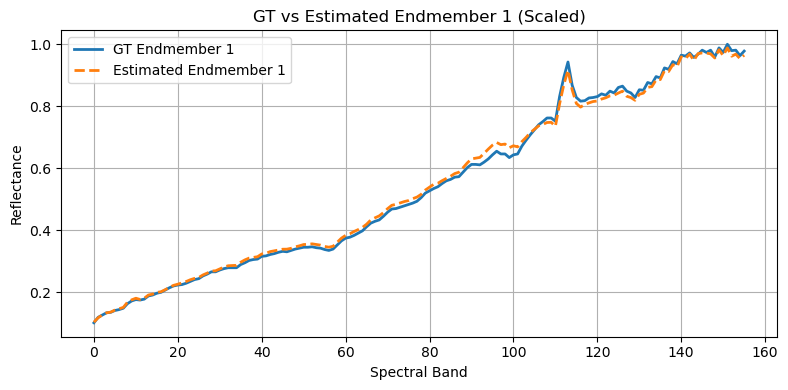

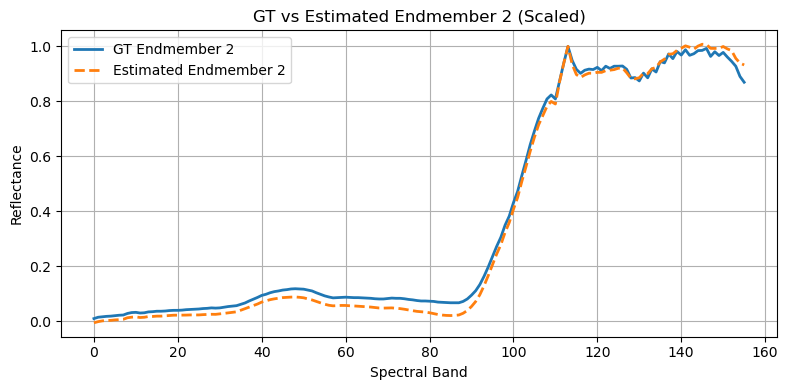

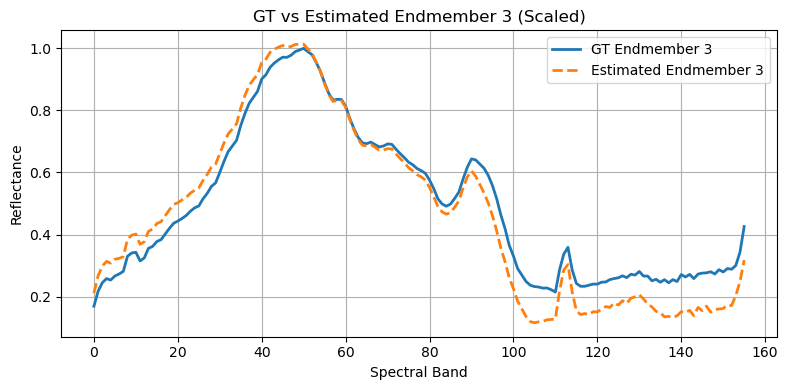

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Denormalize M_matched to match GT scale
# GT shape: (156, 3), M_matched: (156, 3)
# We'll scale each estimated endmember to best fit its corresponding GT
M_scaled = np.zeros_like(M_matched)
for i in range(3):
    scale = np.dot(GT[:, i], M_matched[:, i]) / np.dot(M_matched[:, i], M_matched[:, i])
    M_scaled[:, i] = M_matched[:, i] * scale

# Plot each Ground Truth vs Estimated endmember in separate figures
for i in range(3):
    plt.figure(figsize=(8, 4))
    plt.plot(GT[:, i], label=f'GT Endmember {i+1}', linewidth=2)
    plt.plot(M_scaled[:, i], '--', label=f'Estimated Endmember {i+1}', linewidth=2)
    plt.title(f'GT vs Estimated Endmember {i+1} (Scaled)')
    plt.xlabel('Spectral Band')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


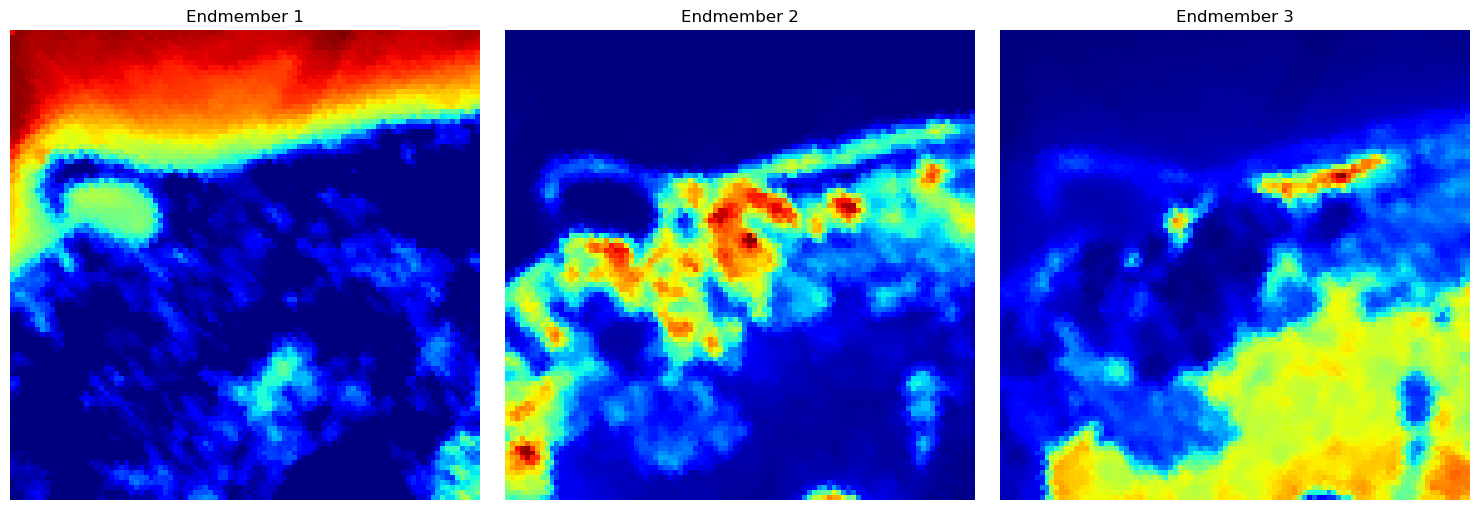

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming A_maps is already computed and has shape (n_endmembers, lines, cols)
n_endmembers = 3
lines = 95
cols = 95

# Create a figure with subplots horizontally
plt.figure(figsize=(15, 5))

# Plotting the Abundance Maps horizontally
for i in range(n_endmembers):
    plt.subplot(1, n_endmembers, i + 1)  # 1 row, n_endmembers columns
    plt.imshow(A_maps[i], cmap='jet')
    plt.title(f'Endmember {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


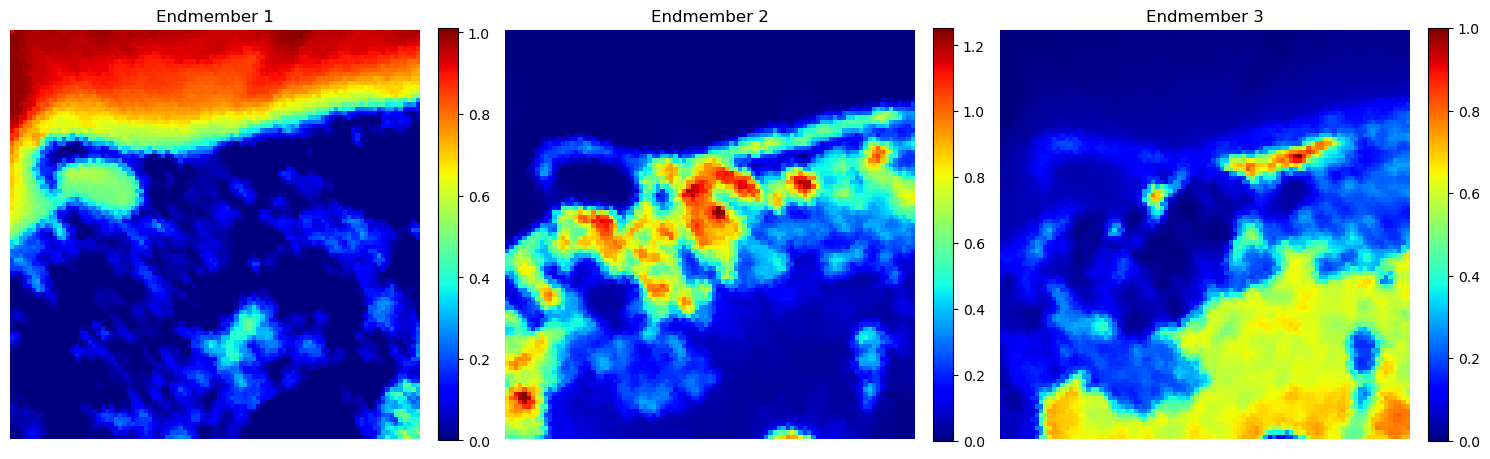

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data for demonstration (remove this if A_maps is already defined)
n_endmembers = 3
lines = 95
cols = 95

# Create a figure with subplots horizontally
fig, axes = plt.subplots(1, n_endmembers, figsize=(15, 5))

# Plotting the Abundance Maps horizontally with colorbars
for i in range(n_endmembers):
    im = axes[i].imshow(A_maps[i], cmap='jet')
    axes[i].set_title(f'Endmember {i + 1}')
    axes[i].axis('off')
    # Add colorbar to the right of each image
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [48]:
def spectral_angle(a, b):
    return np.arccos(np.clip(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)), -1.0, 1.0))

for i in range(3):
    angle = spectral_angle(GT[:, i], M_scaled[:, i])
    print(f"Spectral Angle (GT vs Estimated Endmember {i+1}): {np.degrees(angle):.2f} degrees")


Spectral Angle (GT vs Estimated Endmember 1): 1.19 degrees
Spectral Angle (GT vs Estimated Endmember 2): 2.84 degrees
Spectral Angle (GT vs Estimated Endmember 3): 7.44 degrees


# Urban4 Dataset

Scene: Urban area with man-made materials.

## Image size: 307 × 307 pixels
## Spectral bands: 162

Typical Endmembers (4):
1. Asphalt
2. Grass
3. Tree
4. Roof

This dataset has relatively distinct materials commonly found in urban environments.


In [89]:
data1 = loadmat(r"C:\Users\Ashir\Desktop\Try\Project_minor\Datasets\Urban4.mat")

Y1 = data1['Y']         # (162, 94249)
GT = data1['GT']       # (4, 162)
S_GT = data1['S_GT']   # (307, 307, 4)
lines = int(data1['lines'][0][0])  # 307
cols = int(data1['cols'][0][0])    # 307
n1_endmembers = 4

In [90]:

Y1 = Y1.astype(np.float64)
# Y1_norm = Y1  # Optional normalization

Y1 = data1['Y'].astype(np.float64)  # (bands, pixels)
Y1_norm = Y1 / np.linalg.norm(Y1, axis=0, keepdims=True)

n1_endmembers = 4 #endmember_counts[name]
M1_estimated = vca(Y1_norm, n1_endmembers)[0]

SNR estimated = 27.089997523746028[dB]
... Select the projective proj.


In [93]:
A1 = np.zeros((n1_endmembers, Y1.shape[1]))  # (4, 94249)

for i in range(Y1.shape[1]):
    try:
        abundances, _ = nnls(M1_estimated, Y1[:, i])  # use maxiter if available in your scipy version
        A1[:, i] = abundances
    except RuntimeError:
        print(f"NNLS failed at pixel {i}, filling with zeros.")
        A1[:, i] = np.zeros(n1_endmembers)


A1_maps = A1.reshape((n1_endmembers, lines, cols))

In [105]:
GT = GT.T  # (162, 4)
distances = cdist(GT.T, M1_estimated.T, metric='cosine')  # (4, 4)
# print(distances)
matched_indices = np.argmin(distances, axis=1)

M1_matched = M1_estimated[:, matched_indices]
A1_matched = A1[matched_indices, :]
abundance_maps_matched1 = A1_matched.reshape((n1_endmembers, lines, cols))

[[0.58811429 0.32032058 0.0214857  0.43420707]
 [0.78954729 0.08774183 0.20921333 0.21795609]
 [0.8749859  0.06716588 0.49688426 0.04150194]
 [0.32513525 0.25608907 0.13262161 0.31357673]]


In [95]:
M1_scaled = np.zeros_like(M1_matched)
for i in range(n1_endmembers):
    scale = np.dot(GT[:, i], M1_matched[:, i]) / np.dot(M1_matched[:, i], M1_matched[:, i])
    M1_scaled[:, i] = M1_matched[:, i] * scale

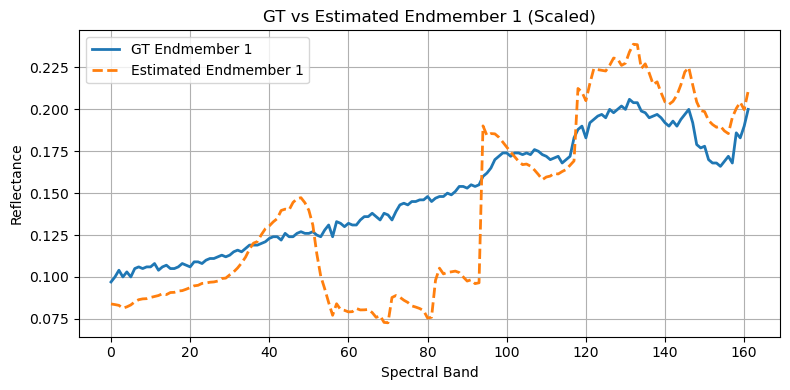

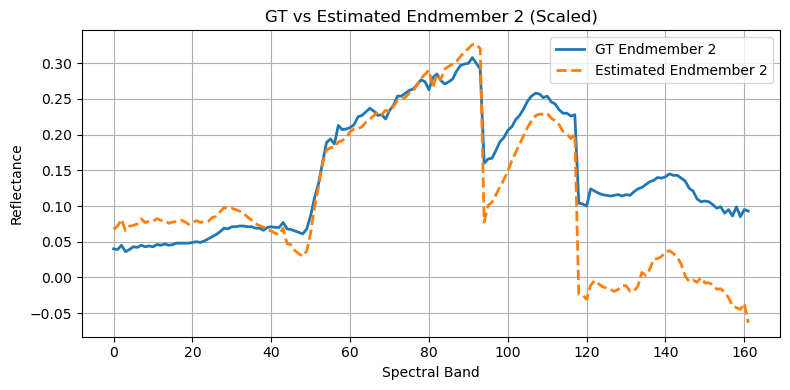

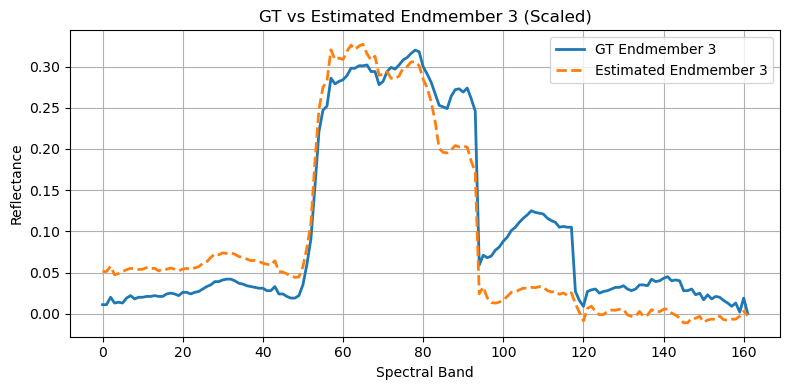

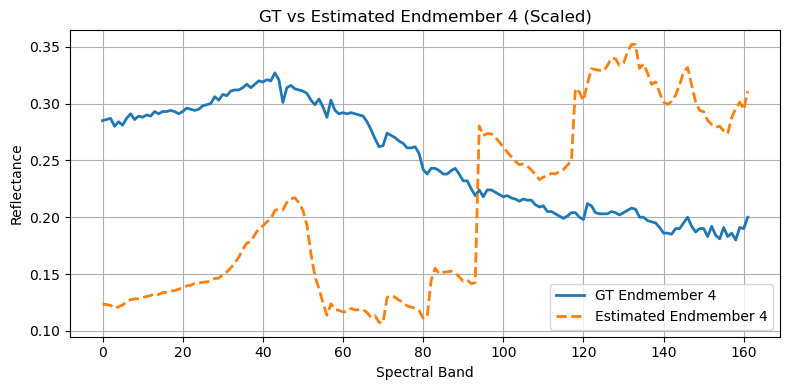

In [96]:

for i in range(n1_endmembers):
    plt.figure(figsize=(8, 4))
    plt.plot(GT[:, i], label=f'GT Endmember {i+1}', linewidth=2)
    plt.plot(M1_scaled[:, i], '--', label=f'Estimated Endmember {i+1}', linewidth=2)
    plt.title(f'GT vs Estimated Endmember {i+1} (Scaled)')
    plt.xlabel('Spectral Band')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [109]:
plt.figure(figsize=(16, 4))

for i in range(n1_endmembers):
    plt.subplot(1, n1_endmembers, i + 1)
    plt.imshow(abundance_maps_matched[i], cmap='jet')
    plt.title(f'Endmember {i + 1}')
    plt.axis('off')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("Abundance for Urban 4.png") 
plt.show()

ValueError: num must be an integer with 1 <= num <= 4, not 0

<Figure size 1600x400 with 0 Axes>

In [ ]:
import numpy as np

def spectral_angle(a, b):
    """Compute the spectral angle (in radians) between two vectors."""
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0:
        return np.nan
    cosine = np.dot(a, b) / (norm_a * norm_b)
    return np.arccos(np.clip(cosine, -1.0, 1.0))

# Loop over all 4 endmembers
for i in range(4):
    angle_rad = spectral_angle(GT[:, i], M_scaled[:, i])
    angle_deg = np.degrees(angle_rad)
    print(f"Spectral Angle (GT vs Estimated Endmember {i+1}): {angle_deg:.2f} degrees")


# Urban5 Dataset

Scene: Urban region (similar to Urban4, different location)

## Image size: 307 × 307 pixels
## Spectral bands: 162

Typical Endmembers (5):
1. Asphalt
2. Grass
3. Tree
4. Roof
5. Metal

Sometimes metal or dirt is included depending on the labeling.


In [77]:
# Load the .mat file
data = loadmat("C:/Users/Ashir/Desktop/Project/Datasets/Urban5.mat")

# Extract variables
Y = data['Y']         # Spectral data: shape (162, 94249)
GT = data['GT']       # Ground Truth Endmembers: shape (5, 162)
S_GT = data['S_GT']   # Ground Truth Abundance maps: shape (307, 307, 5)
lines = int(data['lines'][0][0])  # Image height: 307
cols = int(data['cols'][0][0])    # Image width: 307
n_endmembers = 5

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Ashir/Desktop/Project/Datasets/Urban5.mat'

In [79]:

Y = Y.astype(np.float64)
Y_norm = Y  # If needed: Y / np.linalg.norm(Y, axis=0, keepdims=True)

# ------------------- Apply VCA -------------------

M_estimated = vca(Y_norm, n_endmembers)[0]  # Shape: (162, 5)

SNR estimated = 32.682020112386866[dB]
... Select the projective proj.


In [86]:
from scipy.optimize import lsq_linear

A = np.zeros((n_endmembers, Y.shape[1]))

for i in range(Y.shape[1]):
    result = lsq_linear(M_estimated, Y[:, i], bounds=(0, np.inf), method='trf')
    A[:, i] = result.x


C:\Users\Ashir\anaconda3\Lib\site-packages\scipy\optimize\_lsq\trf_linear.py:116: RuntimeWarning: invalid value encountered in multiply
  r_h = p_h + r_h * r_stride


In [88]:
GT = data['GT'].T  # Shape: (162, 5)
distances = cdist(GT.T, M_estimated.T, metric='cosine')  # shape (5, 5)
matched_indices = np.argmin(distances, axis=1)

M_matched = M_estimated[:, matched_indices]  # reorder columns
A_matched = A[matched_indices, :]            # reorder abundance rows

# Reshape to image format
abundance_maps_matched = A_matched.reshape((n_endmembers, lines, cols))

In [89]:
M_scaled = np.zeros_like(M_matched)
for i in range(n_endmembers):
    scale = np.dot(GT[:, i], M_matched[:, i]) / np.dot(M_matched[:, i], M_matched[:, i])
    M_scaled[:, i] = M_matched[:, i] * scale

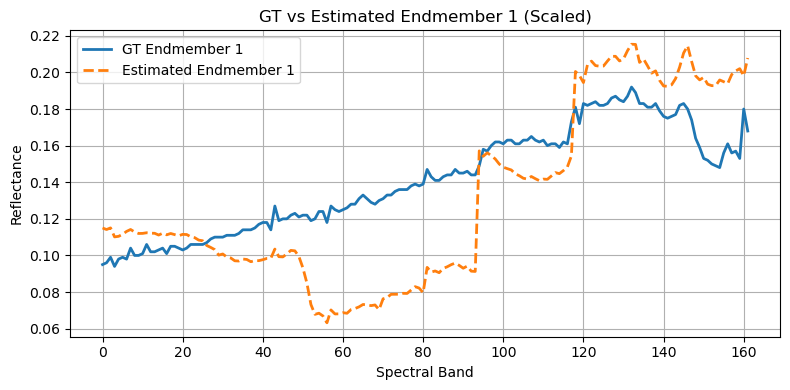

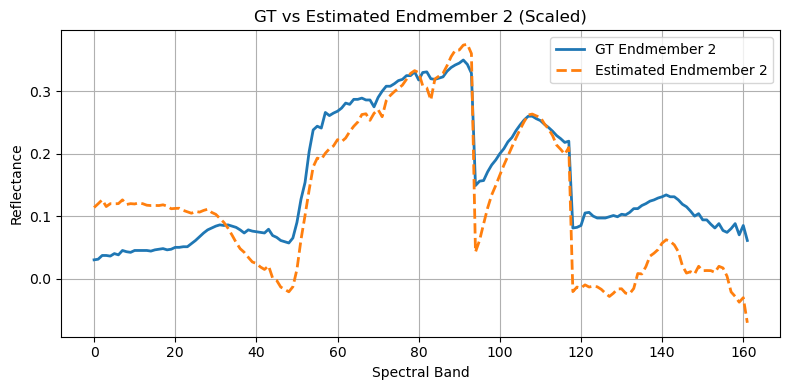

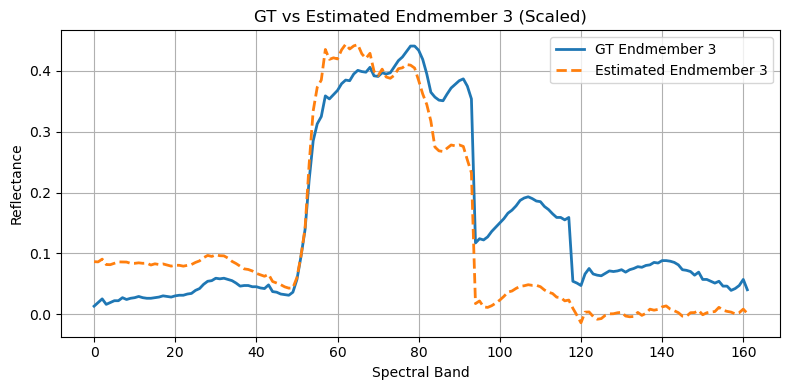

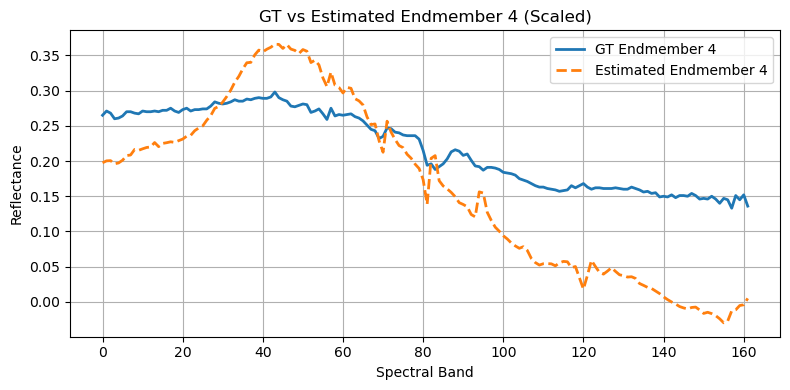

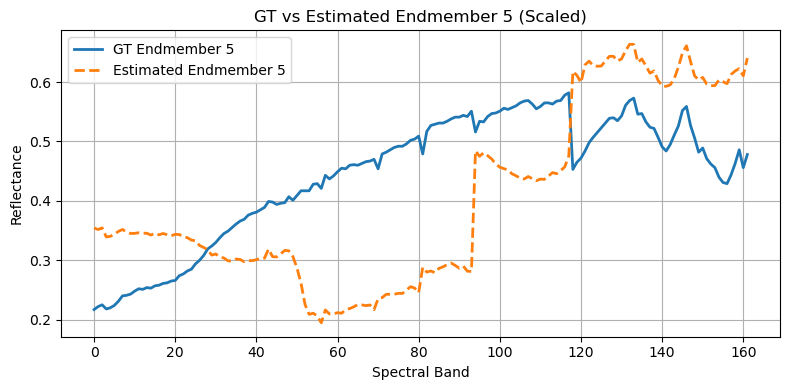

In [90]:
for i in range(n_endmembers):
    plt.figure(figsize=(8, 4))
    plt.plot(GT[:, i], label=f'GT Endmember {i+1}', linewidth=2)
    plt.plot(M_scaled[:, i], '--', label=f'Estimated Endmember {i+1}', linewidth=2)
    plt.title(f'GT vs Estimated Endmember {i+1} (Scaled)')
    plt.xlabel('Spectral Band')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

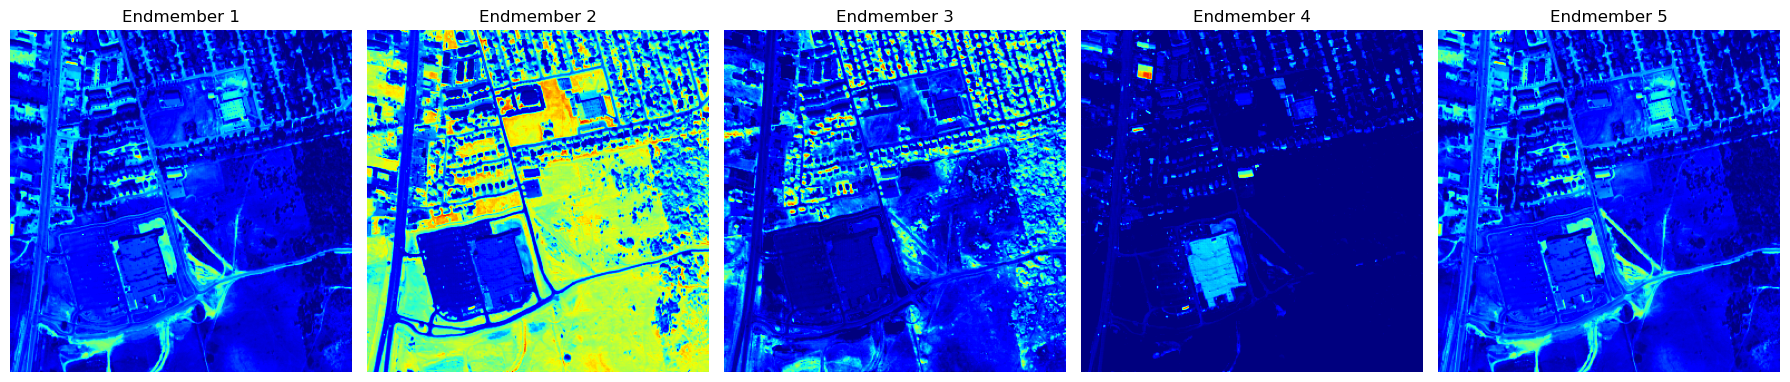

In [91]:
plt.figure(figsize=(18, 4))

for i in range(n_endmembers):
    plt.subplot(1, n_endmembers, i + 1)
    plt.imshow(abundance_maps_matched[i], cmap='jet')
    plt.title(f'Endmember {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Urban6 Dataset

Scene: More complex urban scene

## Image size: 307 × 307 pixels
## Spectral bands: 162

Typical Endmembers (6):
1. Asphalt
2. Grass
3. Tree
4. Roof
5. Dirt/Soil
6. Concrete or Shadow

The dataset is designed to challenge unmixing algorithms with increasing complexity.
